In [2]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os, shutil
import numpy as np
import torch,torchvision

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from Bio.PDB import MMCIFParser, PDBIO
from Bio.PDB import PDBParser, NeighborSearch

from tqdm import tqdm
from pathlib import Path

In [5]:
def evaluate_coordination_number(pdb_path, ion_name, cutoff):
    if ion_name == "CA":
        max_coor = 8
    elif ion_name == "MG":
        max_coor = 6
    elif ion_name == "ZN":
        max_coor = 6

    parser = PDBParser()
    structure = parser.get_structure("structure", pdb_path)

    # Get all atoms in the structure
    atoms = list(structure.get_atoms())
    ns = NeighborSearch(atoms)

    # Find all residues corresponding to the ion
    ion_residues = [
        atom for atom in atoms if atom.get_id()[:len(ion_name)] == ion_name
    ]

    coordination_numbers = {}
    coordination = {}

    for ion in ion_residues:
        # Find nearby atoms within the distance cutoff
        nearby_atoms = ns.search(ion.coord, cutoff)

        # Exclude the ion itself
        coordinated_atoms = [atom.get_id() for atom in nearby_atoms if atom != ion]
        temp = [atom for atom in coordinated_atoms if atom[0] not in ["C","H"]]

        if len(temp) < len(coordinated_atoms):
            coordinated_atoms = temp
        #print(coordinated_atoms)

        # Store the coordination number
        coordination_numbers[ion] = min(len(coordinated_atoms), max_coor)
        coordination[ion] = coordinated_atoms
    return coordination_numbers

In [6]:
def evaluate_coordination_number(pdb_path, ion_name, cutoff):
    """
    Calculate the average coordination number for specified ions across the last N frames.

    Parameters:
    - pdb_path (str): Path to the PDB file.
    - ion_name (str): Name of the ion (e.g., 'CA' for calcium, 'MG' for magnesium).
    - cutoff (float): Distance cutoff (in Å) to consider atoms as coordinating.
    - frames_to_average (int): Number of frames to average over (default is 1).

    Returns:
    - dict: Dictionary with keys as (chain_id, resnum) tuples and values as average coordination numbers.
    """
    # Set maximum coordination number based on ion type
    max_coor = {"CA": 8, "MG": 6, "ZN": 6}.get(ion_name, 6)  # Default to 6 if ion not recognized

    # Parse the PDB file
    parser = PDBParser()
    structure = parser.get_structure("structure", pdb_path)

    # Get all models (frames) and then the last
    models = list(structure.get_models())
    if len(models) == 200:
        print("\nFully simulated. Using the last model.")
        last_model = models[-1]
    else:
        print("\nNot fully simulated.")
        return {}

    # Process last model
    atoms = list(last_model.get_atoms())
    ns = NeighborSearch(atoms)

    # Identify ions in this model (match both atom name and residue name)
    ions = [
        atom for atom in atoms
        if atom.get_id()[:2] == ion_name.upper() and atom.get_parent().get_resname() == ion_name.upper()
    ]

    # Check if any ions were found
    if not ions:
        print("No ions found in the selected model.")
        return {}

    coordination_numbers = {}
    coordination = {}

    # Calculate coordination number for each ion
    for ion in ions:
        # Find nearby atoms within the cutoff distance
        nearby_atoms = ns.search(ion.coord, cutoff)

        # Filter to exclude the ion itself and atoms with element C or H
        coordinated_atoms = [
            atom for atom in nearby_atoms
            if atom != ion and atom.element[0] not in ["C", "H"]
        ]

        coor_residues = [atom.get_parent().get_resname() for atom in coordinated_atoms]
        all_water = all(res == "HOH" for res in coor_residues)

        if not all_water:
            # Store the coordination number, capped at max_coor
            coordination_numbers[ion] = min(len(coordinated_atoms), max_coor)
            coordination[ion] = [atom.get_id() for atom in coordinated_atoms]
        else:
            print("Ion submerged in water")
    return coordination_numbers

In [7]:
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

In [8]:
def coordination_numbers(M, cnt, cutoff):
    samples_dir = '/content/drive/MyDrive/Samuel/Samples'
    samples_dir += f"-{M}"

    parser = PDBParser()
    samples_path = Path(samples_dir)  # Ensure it's a Path object

    all_sample_folders = [folder for folder in samples_path.iterdir() if folder.is_dir()]
    total_samples = len(all_sample_folders)

    results,m = [],0
    for i, sample_folder in enumerate(tqdm(all_sample_folders,
                                           desc="Processing sample folders",
                                           total=total_samples)):
        sample_id = sample_folder.name
        if m == 30: break

        for filename in os.listdir(sample_folder):
            # Check for PDB files
            if filename.endswith(f"{cnt}.pdb") and filename[0] == "o":
                pdb_path = os.path.join(sample_folder, filename)

                try:
                    coordination_numbers = evaluate_coordination_number(pdb_path, M.upper(), cutoff)
                except Exception as e:
                    print(f"\n[ERROR] Failed to process sample '{sample_id}': {e}")
                    continue  # Move on to the next sample even if there's an error

                if len(list(coordination_numbers.items())) > 0:
                    for ion,n in coordination_numbers.items():
                        results.append(n)
                        if i%3 == 0:
                            print(f"Ion {ion} has coordination number: {n}")
                m += 1
    return results

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from collections import Counter

def plot_histogram(M, cnt, cutoff):
    data = coordination_numbers(M, cnt, cutoff)
    data_cnts = Counter(data)

    x = list(data_cnts.keys())
    y = [data_cnts[i] for i in x]

    fig = plt.figure(figsize=(5,5))
    plt.bar(x, y, color='r', edgecolor='black',
            alpha=.75, label=f'Cutoff = {cutoff}Å')
    plt.legend()

    plt.title(f"{M} coordination")
    plt.xlabel("Coordination number")
    plt.ylabel("Frequency")

    # Get current axes and set tick spacing to 1
    ax = plt.gca()
    ax.xaxis.set_major_locator(MultipleLocator(1))
    plt.grid(axis='y', linestyle='--', alpha=.7)

    output_file = f"{M} Coordination Numbers-{cnt}"
    plt.savefig(f"{output_file}.png")
    print(f"Histogram saved as {output_file}")
    return

Processing sample folders:   0%|          | 1/6196 [00:30<52:12:43, 30.34s/it]

Fully simulated. Using the last model.

Ion <Atom CA> has coordination number: 8


Processing sample folders:   0%|          | 2/6196 [00:51<42:52:37, 24.92s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 3/6196 [01:06<35:13:49, 20.48s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 4/6196 [01:15<27:11:32, 15.81s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 5/6196 [01:24<23:11:47, 13.49s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 6/6196 [02:28<52:36:55, 30.60s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 7/6196 [02:41<42:42:54, 24.85s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 8/6196 [03:09<44:28:13, 25.87s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 9/6196 [03:49<52:01:18, 30.27s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 10/6196 [04:53<70:09:17, 40.83s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 11/6196 [04:56<50:12:51, 29.23s/it]

Not fully simulated.


Processing sample folders:   0%|          | 12/6196 [05:21<47:57:22, 27.92s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 13/6196 [05:58<52:14:44, 30.42s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 14/6196 [06:38<57:39:59, 33.58s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 15/6196 [07:03<53:08:54, 30.96s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 16/6196 [07:44<58:00:08, 33.79s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 17/6196 [08:01<49:36:22, 28.90s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 18/6196 [08:18<43:12:15, 25.18s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 19/6196 [08:31<37:15:39, 21.72s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 20/6196 [09:29<55:52:36, 32.57s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 21/6196 [09:31<39:55:35, 23.28s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 22/6196 [10:09<47:35:45, 27.75s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 23/6196 [10:18<37:51:06, 22.07s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 24/6196 [10:33<34:04:54, 19.88s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 25/6196 [11:51<64:03:29, 37.37s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 26/6196 [11:55<47:11:12, 27.53s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 27/6196 [12:48<60:10:30, 35.12s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 28/6196 [13:15<55:55:59, 32.65s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 29/6196 [13:33<48:24:34, 28.26s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 30/6196 [14:50<50:50:41, 29.69s/it]

Fully simulated. Using the last model.
Histogram saved as Ca Coordination Numbers-1


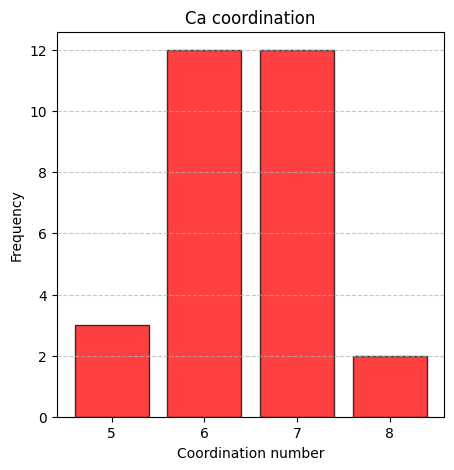

In [ ]:
plot_histogram('Ca', '1', 2.6)

Processing sample folders:   0%|          | 5/5776 [01:03<36:23:54, 22.71s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 32/5776 [01:50<19:51:18, 12.44s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 33/5776 [02:00<18:46:27, 11.77s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   1%|          | 34/5776 [02:32<28:28:15, 17.85s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 35/5776 [03:10<38:18:05, 24.02s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 36/5776 [03:42<42:10:07, 26.45s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 37/5776 [04:17<46:13:29, 29.00s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 38/5776 [05:10<57:41:09, 36.19s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 39/5776 [05:19<44:20:23, 27.82s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 40/5776 [06:09<55:09:20, 34.62s/it]

Not fully simulated.


Processing sample folders:   1%|          | 41/5776 [06:30<48:29:59, 30.44s/it]

Fully simulated. Using the last model.
Fully simulated. Using the last model.


Processing sample folders:   1%|          | 43/5776 [07:41<49:01:05, 30.78s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 44/5776 [08:16<50:44:39, 31.87s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 45/5776 [08:23<39:02:07, 24.52s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 46/5776 [09:34<61:20:29, 38.54s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 47/5776 [09:40<45:54:17, 28.85s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 48/5776 [10:02<42:29:21, 26.70s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 49/5776 [10:36<45:39:45, 28.70s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 50/5776 [10:50<38:45:57, 24.37s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 51/5776 [11:12<37:53:53, 23.83s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 52/5776 [11:25<32:27:26, 20.41s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 53/5776 [12:06<42:28:21, 26.72s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 54/5776 [12:30<40:50:32, 25.70s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 55/5776 [13:48<66:13:25, 41.67s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 56/5776 [14:08<55:40:53, 35.04s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 57/5776 [14:14<41:51:55, 26.35s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 58/5776 [15:07<54:16:30, 34.17s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 59/5776 [15:22<45:10:54, 28.45s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 60/5776 [15:36<24:46:38, 15.60s/it]

Fully simulated. Using the last model.
Histogram saved as Mg Coordination Numbers-1


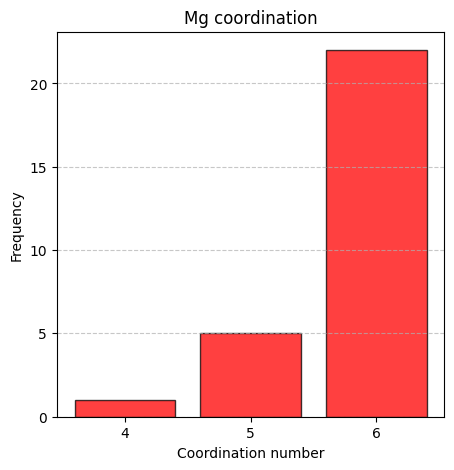

In [ ]:
plot_histogram('Mg', '1', 2.3)

In [ ]:
plot_histogram('Zn', '1', 2.)

Processing sample folders:   0%|          | 1/6550 [01:12<131:01:28, 72.02s/it]

Fully simulated. Using the last model.

Ion <Atom ZN> has coordination number: 5


Processing sample folders:   0%|          | 2/6550 [01:29<72:12:31, 39.70s/it] 

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 3/6550 [01:45<52:39:15, 28.95s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 4/6550 [02:51<79:30:02, 43.72s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 5/6550 [03:21<70:19:02, 38.68s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 6/6550 [03:39<57:18:26, 31.53s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 7/6550 [03:50<45:06:28, 24.82s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 8/6550 [05:12<78:36:41, 43.26s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 9/6550 [05:15<55:21:38, 30.47s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 10/6550 [05:22<42:27:56, 23.38s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 11/6550 [06:01<50:55:06, 28.03s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 12/6550 [06:33<53:10:47, 29.28s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 13/6550 [06:48<45:28:12, 25.04s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 14/6550 [07:45<62:46:43, 34.58s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 15/6550 [08:13<59:16:27, 32.65s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 16/6550 [08:20<45:21:40, 24.99s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 17/6550 [08:42<43:24:12, 23.92s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 18/6550 [08:50<35:02:31, 19.31s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 19/6550 [09:28<45:13:05, 24.93s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 20/6550 [09:59<48:38:25, 26.82s/it]

Fully simulated. Using the last model.


Processing sample folders:  72%|███████▏  | 4466/6196 [00:03<00:02, 583.89it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom OD2>]
[<Atom OE1>, <Atom O>, <Atom O>, <Atom OXT>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  88%|████████▊ | 5458/6196 [00:03<00:00, 1392.22it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OE2>]


Processing sample folders:  91%|█████████▏| 5663/6196 [00:28<00:17, 30.82it/s]  

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OD2>]


Processing sample folders:  91%|█████████▏| 5664/6196 [00:45<00:33, 16.06it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom NE2>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>]


Processing sample folders:  91%|█████████▏| 5665/6196 [00:52<00:42, 12.47it/s]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom OD2>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OXT>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OXT>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>]


Processing sample folders:  91%|█████████▏| 5668/6196 [01:05<01:06,  7.98it/s]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>]


Processing sample folders:  91%|█████████▏| 5669/6196 [01:07<01:12,  7.24it/s]

Multiple models found: 50. Using the last model.
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5680/6196 [01:24<02:06,  4.08it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>]
[<Atom OD2>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5681/6196 [01:31<02:39,  3.23it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5683/6196 [01:58<05:38,  1.52it/s]

Multiple models found: 50. Using the last model.
[<Atom OG>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OE1>, <Atom OE2>, <Atom O>]
[<Atom OD2>, <Atom OE2>, <Atom OD1>, <Atom OD2>, <Atom OD1>, <Atom OE1>]


Processing sample folders:  92%|█████████▏| 5684/6196 [02:01<06:04,  1.41it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>, <Atom O>]
[<Atom OD1>, <Atom OD2>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OE1>, <Atom OG>]


Processing sample folders:  92%|█████████▏| 5685/6196 [02:24<10:53,  1.28s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OG1>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OD1>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5687/6196 [02:38<14:25,  1.70s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom OD2>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5688/6196 [02:48<17:25,  2.06s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OXT>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD2>, <Atom OD2>, <Atom O>, <Atom OD1>, <Atom OD2>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom OXT>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>]
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5691/6196 [03:11<25:20,  3.01s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom OG1>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5692/6196 [03:17<27:08,  3.23s/it]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OD2>]


Processing sample folders:  92%|█████████▏| 5693/6196 [03:28<33:37,  4.01s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom OE2>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OG1>, <Atom OE2>]


Processing sample folders:  92%|█████████▏| 5718/6196 [03:32<08:14,  1.03s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom OG1>]
[<Atom OD1>, <Atom OXT>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>]


Processing sample folders:  94%|█████████▍| 5838/6196 [03:41<01:20,  4.42it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom OD2>, <Atom OD2>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE2>, <Atom OD2>, <Atom OD1>, <Atom OD1>]
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OE2>]


Processing sample folders:  94%|█████████▍| 5843/6196 [03:59<02:16,  2.59it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom OXT>, <Atom O>]
[<Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>]


Processing sample folders:  95%|█████████▌| 5897/6196 [04:03<01:16,  3.91it/s]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>]


Processing sample folders:  95%|█████████▌| 5916/6196 [04:09<01:14,  3.76it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OD2>]
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>]


Processing sample folders:  98%|█████████▊| 6079/6196 [04:22<00:16,  7.14it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE2>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  98%|█████████▊| 6082/6196 [04:33<00:23,  4.95it/s]

Multiple models found: 50. Using the last model.
[<Atom OG1>, <Atom OG>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom OD2>, <Atom OD2>]


Processing sample folders: 100%|██████████| 6196/6196 [04:46<00:00, 21.60it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom OD1>, <Atom OE2>, <Atom OD2>, <Atom OE1>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom OD2>, <Atom OD1>]
60
Counter({7: 33, 6: 18, 5: 6, 4: 2, 8: 1})
Histogram saved as Ca Coordination Numbers-2


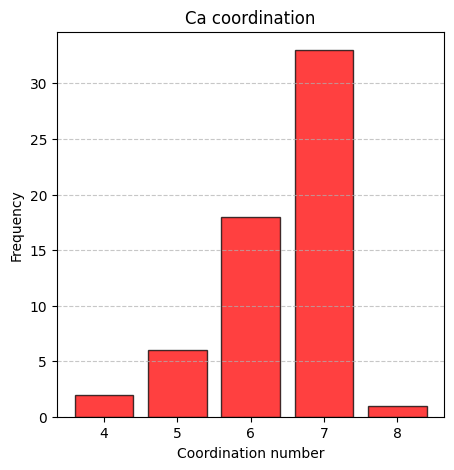

In [ ]:
plot_histogram('Ca', '2', 2.6)

Processing sample folders:  69%|██████▉   | 4007/5776 [00:01<00:00, 2271.91it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD2>, <Atom OD1>, <Atom OE2>, <Atom OE1>, <Atom OG>]
[<Atom OD2>, <Atom OD1>, <Atom O>, <Atom OE1>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4212/5776 [00:29<00:57, 27.09it/s]  

Multiple models found: 50. Using the last model.
[<Atom OG1>, <Atom OD2>, <Atom O>, <Atom OG>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4213/5776 [00:40<01:28, 17.64it/s]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>]


Processing sample folders:  73%|███████▎  | 4214/5776 [00:45<01:50, 14.16it/s]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom OD2>, <Atom O>, <Atom OE1>, <Atom OG1>, <Atom OD1>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4214/5776 [00:58<01:50, 14.16it/s]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4216/5776 [01:11<04:18,  6.04it/s]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OE1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4217/5776 [01:20<05:39,  4.59it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OXT>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4217/5776 [01:40<05:39,  4.59it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4219/5776 [01:48<10:53,  2.38it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom O>, <Atom OD1>, <Atom OE1>, <Atom OD2>, <Atom O>, <Atom OE2>]


Processing sample folders:  73%|███████▎  | 4220/5776 [01:59<13:56,  1.86it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom OE1>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4221/5776 [02:15<19:45,  1.31it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom OD1>]


Processing sample folders:  73%|███████▎  | 4222/5776 [02:38<31:54,  1.23s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>]
[<Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom OE1>, <Atom OE2>]


Processing sample folders:  73%|███████▎  | 4223/5776 [02:43<34:47,  1.34s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom OE2>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OG1>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom OE2>, <Atom OE1>]


Processing sample folders:  73%|███████▎  | 4225/5776 [03:12<1:00:37,  2.35s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD2>, <Atom OD1>, <Atom OE1>, <Atom O>, <Atom OXT>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4226/5776 [03:30<1:21:11,  3.14s/it]

Multiple models found: 50. Using the last model.
[<Atom OG>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom OD1>, <Atom OD2>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>]


Processing sample folders:  73%|███████▎  | 4227/5776 [03:39<1:32:59,  3.60s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom NE2>, <Atom OE1>, <Atom O>, <Atom OE2>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom OD1>, <Atom OE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>]


Processing sample folders:  73%|███████▎  | 4230/5776 [04:11<2:14:12,  5.21s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OD2>, <Atom OE1>]
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom OD2>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4231/5776 [04:13<2:05:52,  4.89s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OG1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4232/5776 [04:35<3:00:39,  7.02s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD2>, <Atom O>, <Atom OD1>, <Atom OE1>, <Atom OE2>]
[<Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4233/5776 [04:42<3:00:35,  7.02s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OH>, <Atom OXT>, <Atom OE2>, <Atom OE1>, <Atom O>]
[<Atom OD2>, <Atom OD1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OE1>]
Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OE1>, <Atom OE2>]
[<Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>]


Processing sample folders:  73%|███████▎  | 4235/5776 [05:12<3:59:25,  9.32s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>]
[<Atom OE2>, <Atom NE2>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom OE1>]


Processing sample folders:  73%|███████▎  | 4236/5776 [05:18<3:46:33,  8.83s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OD1>, <Atom O>, <Atom OE1>, <Atom OD2>, <Atom O>]
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom OD1>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4237/5776 [05:34<4:18:49, 10.09s/it]

Multiple models found: 50. Using the last model.
[<Atom OE1>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OG>, <Atom O>, <Atom OD1>, <Atom OD2>]


Processing sample folders:  78%|███████▊  | 4493/5776 [06:02<03:44,  5.70it/s]  

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom O>, <Atom OD2>, <Atom OD2>, <Atom OD1>, <Atom OD1>, <Atom OD1>]


Processing sample folders:  86%|████████▋ | 4986/5776 [06:02<00:31, 24.73it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5316/5776 [06:23<00:20, 22.34it/s]

Multiple models found: 50. Using the last model.
[<Atom OXT>, <Atom O>, <Atom OD2>, <Atom O>, <Atom OD2>]
[<Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders: 100%|██████████| 5776/5776 [06:23<00:00, 15.06it/s]


62
Counter({6: 54, 5: 5, 4: 3})
Histogram saved as Mg Coordination Numbers-2


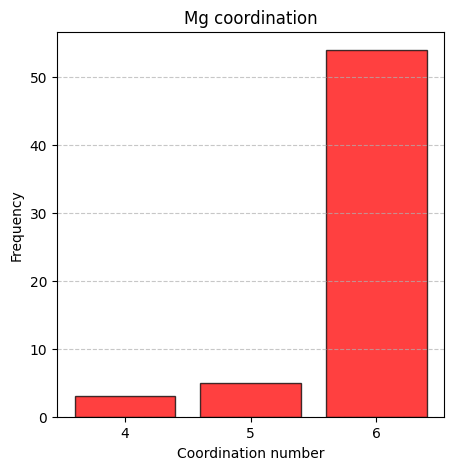

In [ ]:
plot_histogram('Mg', '2', 2.3)

Processing sample folders:   0%|          | 1/6550 [00:21<38:43:22, 21.29s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom OD2>]
[<Atom NE2>, <Atom OE2>, <Atom OE1>, <Atom O>, <Atom O>]

Ion <Atom ZN> has coordination number: 4

Ion <Atom ZN> has coordination number: 5


Processing sample folders:   0%|          | 2/6550 [00:26<21:56:18, 12.06s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OD1>]


Processing sample folders:   0%|          | 3/6550 [00:34<18:02:41,  9.92s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OE2>]
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OD2>]


Processing sample folders:   0%|          | 4/6550 [00:51<23:07:22, 12.72s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom NE2>, <Atom NE2>, <Atom O>, <Atom OD2>, <Atom OD1>]


Processing sample folders:   0%|          | 5/6550 [01:02<22:20:41, 12.29s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OXT>, <Atom O>, <Atom OE2>, <Atom OE1>]
[<Atom OD1>, <Atom NE2>, <Atom OD2>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 6/6550 [01:11<20:13:47, 11.13s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 7/6550 [01:14<15:02:32,  8.28s/it]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>]
[<Atom OE2>, <Atom OE2>, <Atom OE1>, <Atom OE1>, <Atom O>]


Processing sample folders:   0%|          | 8/6550 [01:45<28:23:55, 15.63s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom OE1>]
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 9/6550 [01:46<20:20:19, 11.19s/it]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom OD2>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom OD2>, <Atom OD1>]


Processing sample folders:   0%|          | 10/6550 [01:49<15:44:45,  8.67s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OXT>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 11/6550 [02:04<19:01:29, 10.47s/it]

Multiple models found: 50. Using the last model.
[<Atom OE1>, <Atom OE2>, <Atom OD1>, <Atom OD2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>]


Processing sample folders:   0%|          | 12/6550 [02:12<17:54:58,  9.87s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom NE2>, <Atom OD1>, <Atom OD2>]
[<Atom NE2>, <Atom OE1>, <Atom OE2>, <Atom O>]


Processing sample folders:   0%|          | 13/6550 [02:18<15:40:27,  8.63s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom NE2>, <Atom O>, <Atom O>]
[<Atom NE2>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OE2>]


Processing sample folders:   0%|          | 14/6550 [02:36<20:37:01, 11.36s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE2>, <Atom OE1>, <Atom OD1>, <Atom ND1>]
[<Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>]


Processing sample folders:   0%|          | 15/6550 [02:44<18:55:48, 10.43s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>]
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom OD2>]


Processing sample folders:   0%|          | 16/6550 [02:52<17:19:54,  9.55s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom NE2>, <Atom OE2>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom OD2>]


Processing sample folders:   0%|          | 17/6550 [02:56<14:44:51,  8.13s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom NE2>, <Atom OD1>]
[<Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 18/6550 [03:00<11:58:08,  6.60s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OXT>, <Atom O>, <Atom O>]
[<Atom OE1>, <Atom OD2>, <Atom O>, <Atom OD1>, <Atom O>]


Processing sample folders:   0%|          | 19/6550 [03:11<14:41:46,  8.10s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom NE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>]


Processing sample folders:   0%|          | 20/6550 [03:25<17:56:04,  9.89s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OXT>, <Atom O>]
[<Atom OE1>, <Atom OE2>, <Atom NE2>, <Atom NE2>, <Atom OG1>]


Processing sample folders:   0%|          | 21/6550 [03:28<13:55:34,  7.68s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OXT>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom OE1>, <Atom OE2>]


Processing sample folders:   0%|          | 22/6550 [03:52<23:00:09, 12.69s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom NE2>, <Atom OD1>, <Atom O>, <Atom OD2>, <Atom NE2>]


Processing sample folders:   0%|          | 23/6550 [04:00<20:22:17, 11.24s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OG>, <Atom O>]
[<Atom OD2>, <Atom OD1>, <Atom NE2>, <Atom OD1>, <Atom OD2>, <Atom O>]


Processing sample folders:   0%|          | 24/6550 [04:12<21:02:22, 11.61s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD2>, <Atom O>]


Processing sample folders:   0%|          | 25/6550 [04:17<17:21:43,  9.58s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OXT>]


Processing sample folders:   0%|          | 26/6550 [04:34<21:10:22, 11.68s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom OD2>, <Atom NE2>]
[<Atom OG>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>]


Processing sample folders:   0%|          | 27/6550 [04:36<15:54:30,  8.78s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom NE2>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD2>, <Atom OD1>, <Atom OD1>, <Atom O>, <Atom OE1>]


Processing sample folders:   0%|          | 28/6550 [04:45<15:52:50,  8.77s/it]

Multiple models found: 50. Using the last model.
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>]
[<Atom OE1>, <Atom OE2>, <Atom OE2>, <Atom OE1>, <Atom O>, <Atom OE2>]


Processing sample folders:   0%|          | 29/6550 [04:52<15:12:24,  8.40s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom NE2>, <Atom OE2>, <Atom OE1>, <Atom O>]


Processing sample folders:   0%|          | 30/6550 [05:01<15:16:21,  8.43s/it]

Multiple models found: 50. Using the last model.
[<Atom OE1>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>]
[<Atom OD2>, <Atom OD1>, <Atom O>, <Atom NE2>]


Processing sample folders:   4%|▍         | 266/6550 [05:08<08:23, 12.47it/s]  

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom OD1>]
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>]


Processing sample folders: 100%|██████████| 6550/6550 [05:11<00:00, 21.01it/s]  


62
Counter({5: 37, 6: 13, 4: 12})
Histogram saved as Zn Coordination Numbers-2


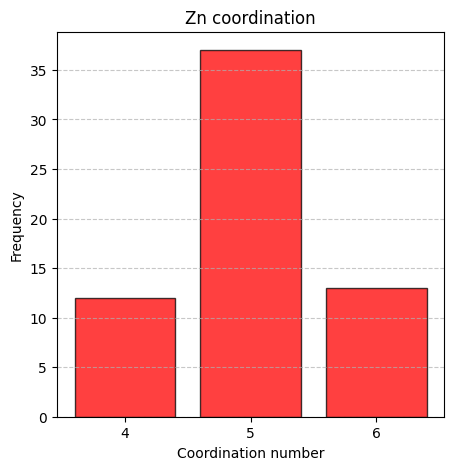

In [ ]:
plot_histogram('Zn', '2', 2.)

Processing sample folders:  72%|███████▏  | 4468/6196 [00:07<00:09, 181.88it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OD2>]
[<Atom OE1>, <Atom O>, <Atom O>, <Atom O>, <Atom OXT>]


Processing sample folders:  88%|████████▊ | 5449/6196 [00:07<00:01, 643.12it/s]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom OD2>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>]


Processing sample folders:  91%|█████████▏| 5663/6196 [00:30<00:16, 32.33it/s] 

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>]
[<Atom OD2>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OXT>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>]


Processing sample folders:  91%|█████████▏| 5665/6196 [00:36<00:22, 23.93it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE1>, <Atom OD1>, <Atom O>]
[<Atom O>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE2>, <Atom OD2>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OXT>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  91%|█████████▏| 5668/6196 [00:49<00:39, 13.32it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OD2>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>, <Atom OG>]
[<Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  91%|█████████▏| 5669/6196 [00:50<00:41, 12.55it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE1>, <Atom OE2>]
[<Atom OE1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>]


Processing sample folders:  92%|█████████▏| 5680/6196 [01:09<01:27,  5.86it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OXT>, <Atom ND1>, <Atom O>]
[<Atom NE2>, <Atom OG1>, <Atom O>, <Atom O>, <Atom OD1>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD1>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5681/6196 [01:16<01:50,  4.68it/s]

Multiple models found: 50. Using the last model.
[<Atom OE1>, <Atom OD2>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>]
Multiple models found: 50. Using the last model.
[<Atom OG>, <Atom NE2>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>]


Processing sample folders:  92%|█████████▏| 5687/6196 [01:36<03:23,  2.51it/s]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom OG>, <Atom OXT>, <Atom OD2>, <Atom OE1>, <Atom O>]
[<Atom OD1>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom OD2>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom OH>]


Processing sample folders:  92%|█████████▏| 5688/6196 [01:43<04:07,  2.06it/s]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OE1>]
[<Atom OD1>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OD2>, <Atom OD1>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom OD2>, <Atom OD1>]
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom OXT>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>]
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OE1>]


Processing sample folders:  92%|█████████▏| 5691/6196 [02:07<07:35,  1.11it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>, <Atom O>]
[<Atom OD2>, <Atom OD2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>]


Processing sample folders:  92%|█████████▏| 5692/6196 [02:14<08:43,  1.04s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom OE2>, <Atom OE1>]
[<Atom O>, <Atom OE2>, <Atom OD1>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OE2>, <Atom OE1>]
[<Atom OE1>, <Atom OG>, <Atom OE1>, <Atom OE2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>]


Processing sample folders:  92%|█████████▏| 5718/6196 [02:30<06:43,  1.19it/s]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]
[<Atom O>, <Atom OD2>, <Atom OXT>, <Atom O>, <Atom O>, <Atom OE2>]


Processing sample folders:  94%|█████████▍| 5838/6196 [02:40<01:35,  3.77it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>]
[<Atom OD1>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>]
[<Atom OD1>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>]


Processing sample folders:  94%|█████████▍| 5840/6196 [02:48<01:56,  3.06it/s]

Multiple models found: 33. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>]
[<Atom OE1>, <Atom OD1>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OXT>, <Atom O>]


Processing sample folders:  95%|█████████▍| 5867/6196 [02:57<01:48,  3.04it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OG>, <Atom O>, <Atom OD1>, <Atom OD2>]
[<Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  95%|█████████▌| 5897/6196 [03:02<01:24,  3.53it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OD2>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  95%|█████████▌| 5916/6196 [03:08<01:20,  3.47it/s]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OE1>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OD2>]
[<Atom OD2>, <Atom O>, <Atom OD1>, <Atom OE2>, <Atom OE1>, <Atom O>, <Atom OE2>]


Processing sample folders:  98%|█████████▊| 6079/6196 [03:20<00:15,  7.36it/s]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom O>, <Atom OD2>, <Atom OE2>, <Atom OE1>, <Atom O>, <Atom OE1>]


Processing sample folders:  98%|█████████▊| 6082/6196 [03:33<00:24,  4.65it/s]

Multiple models found: 50. Using the last model.
[<Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OG1>, <Atom OD2>, <Atom OD1>, <Atom O>]


Processing sample folders: 100%|██████████| 6196/6196 [03:46<00:00, 27.36it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE2>, <Atom O>, <Atom OD2>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OD2>, <Atom OG1>, <Atom O>, <Atom OH>, <Atom OD1>, <Atom O>]
81
Counter({7: 36, 6: 23, 5: 14, 8: 5, 4: 2, 2: 1})
Histogram saved as Ca Coordination Numbers-3


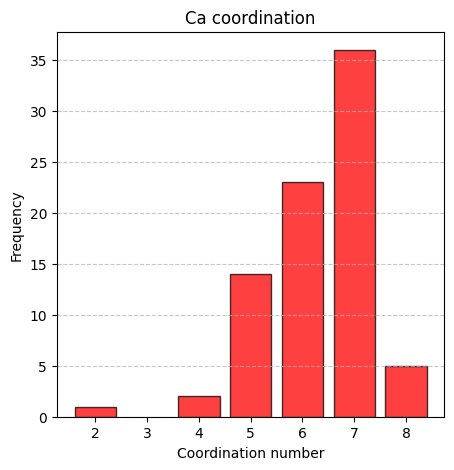

In [ ]:
plot_histogram('Ca', '3', 2.6)

Processing sample folders:  71%|███████   | 4106/5776 [00:02<00:00, 1991.76it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom OD1>, <Atom OD2>, <Atom OD2>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD2>, <Atom O>, <Atom OG>, <Atom OD1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OE1>]
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4195/5776 [00:23<00:59, 26.36it/s]  

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>]
[<Atom OE1>, <Atom O>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom OE2>]
[<Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom OD2>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4196/5776 [00:24<01:04, 24.58it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OG>, <Atom OE1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom NE2>]


Processing sample folders:  73%|███████▎  | 4212/5776 [00:55<03:40,  7.08it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OG>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>]


Processing sample folders:  73%|███████▎  | 4213/5776 [01:06<05:03,  5.14it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>]
[<Atom OD1>, <Atom O>, <Atom O>, <Atom NE2>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4214/5776 [01:07<05:15,  4.95it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OE2>]
[<Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OG1>, <Atom OD1>]
[<Atom O>, <Atom OE1>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>]


Processing sample folders:  73%|███████▎  | 4215/5776 [01:22<08:44,  2.98it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4216/5776 [01:34<13:04,  1.99it/s]

Multiple models found: 50. Using the last model.
[<Atom OE1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>]
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom OD1>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4217/5776 [01:47<19:14,  1.35it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OG>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom OE2>, <Atom OE1>]
[<Atom OE1>, <Atom OE2>, <Atom OE2>, <Atom OE1>, <Atom OE2>, <Atom OE1>]


Processing sample folders:  73%|███████▎  | 4218/5776 [02:06<31:19,  1.21s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4219/5776 [02:11<35:04,  1.35s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>]
[<Atom OE2>, <Atom O>, <Atom OD2>, <Atom OD2>, <Atom OD1>]
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4220/5776 [02:26<53:09,  2.05s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4221/5776 [02:41<1:14:45,  2.88s/it]

Multiple models found: 46. Using the last model.
[<Atom O>, <Atom O>, <Atom NE2>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom OD1>, <Atom OD2>, <Atom OD1>, <Atom OG>]


Processing sample folders:  73%|███████▎  | 4222/5776 [03:04<1:58:39,  4.58s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>]


Processing sample folders:  73%|███████▎  | 4223/5776 [03:13<2:11:17,  5.07s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OE2>, <Atom OD1>, <Atom O>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom OD1>]
[<Atom O>, <Atom OD1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OE1>]
Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom OE1>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE2>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4225/5776 [03:39<3:01:27,  7.02s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE2>, <Atom O>, <Atom OD2>, <Atom O>, <Atom OD1>]
[<Atom O>, <Atom NE2>, <Atom O>, <Atom OD1>, <Atom O>]
[<Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>, <Atom OG>]


Processing sample folders:  73%|███████▎  | 4226/5776 [03:58<3:44:52,  8.70s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OE2>, <Atom O>, <Atom OG1>, <Atom OD1>]
[<Atom OE1>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>]
[<Atom O>, <Atom OG>, <Atom O>, <Atom OD1>, <Atom O>, <Atom OD2>]


Processing sample folders:  73%|███████▎  | 4227/5776 [04:09<3:54:51,  9.10s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4228/5776 [04:10<3:15:30,  7.58s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>]
Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom OD1>, <Atom O>, <Atom OE2>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom NE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4232/5776 [04:40<3:10:58,  7.42s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OG1>, <Atom O>, <Atom OH>, <Atom OE1>, <Atom OE2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OD1>]


Processing sample folders:  73%|███████▎  | 4233/5776 [04:49<3:19:39,  7.76s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom OG1>]
[<Atom OD1>, <Atom OD2>, <Atom OE1>, <Atom O>, <Atom OG1>, <Atom OG>]
[<Atom OXT>, <Atom O>, <Atom OD1>, <Atom OE1>, <Atom OD2>, <Atom OE2>]
Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom OD1>, <Atom O>, <Atom OD2>]
[<Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4235/5776 [05:16<4:06:31,  9.60s/it]

Multiple models found: 50. Using the last model.
[<Atom OE1>, <Atom OE2>, <Atom OG1>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OD2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>]
[<Atom OD1>, <Atom OD1>, <Atom OE1>, <Atom OD2>, <Atom OD2>, <Atom OE2>]


Processing sample folders:  73%|███████▎  | 4236/5776 [05:19<3:34:51,  8.37s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom O>, <Atom OE2>, <Atom OD2>, <Atom O>]
[<Atom OD2>, <Atom OE2>, <Atom OG1>, <Atom O>, <Atom OD1>, <Atom OE1>]
[<Atom OE2>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom OE1>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom OG>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OD2>]
[<Atom O>, <Atom OD1>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom OE1>, <Atom O>, <Atom NE2>, <Atom OD1>, <Atom OD2>]


Processing sample folders:  73%|███████▎  | 4238/5776 [05:40<3:52:16,  9.06s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OD2>, <Atom O>, <Atom OD1>, <Atom OE1>, <Atom O>]
[<Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4239/5776 [05:45<3:32:14,  8.29s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom OE2>, <Atom O>, <Atom OD1>, <Atom OE1>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>]
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom OD1>, <Atom OD2>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4241/5776 [06:00<3:25:31,  8.03s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OE1>]
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom OE1>]


Processing sample folders:  73%|███████▎  | 4242/5776 [06:07<3:18:36,  7.77s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom OE1>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom O>, <Atom OE1>, <Atom OD2>]
[<Atom O>, <Atom OE2>, <Atom OD1>, <Atom OE2>, <Atom OD2>]
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  73%|███████▎  | 4244/5776 [06:27<3:41:17,  8.67s/it]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OE1>, <Atom OE2>, <Atom OE2>, <Atom O>, <Atom OD2>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom OE2>]


Processing sample folders:  73%|███████▎  | 4245/5776 [06:38<3:48:42,  8.96s/it]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom OD1>, <Atom O>, <Atom OXT>, <Atom O>]
[<Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OD2>, <Atom OD1>]
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom OD2>, <Atom O>]


Processing sample folders:  74%|███████▎  | 4246/5776 [06:50<4:06:01,  9.65s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OXT>]


Processing sample folders:  74%|███████▎  | 4247/5776 [06:55<3:36:26,  8.49s/it]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom OE1>, <Atom OD1>]
[<Atom OD1>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OE2>]
Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom OE1>, <Atom OD1>, <Atom OD2>, <Atom OD1>]
[<Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom OD1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom OG>]


Processing sample folders:  74%|███████▎  | 4249/5776 [07:25<4:46:21, 11.25s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom OD1>, <Atom OD1>, <Atom OE1>, <Atom OD2>]
[<Atom OE2>, <Atom OE1>, <Atom OE1>, <Atom OE2>, <Atom O>]
[<Atom O>, <Atom NE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:  77%|███████▋  | 4443/5776 [07:33<03:39,  6.07it/s]  

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OE1>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>, <Atom O>]
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>]


Processing sample folders:  88%|████████▊ | 5095/5776 [07:50<00:40, 16.79it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom OE2>, <Atom O>, <Atom OE1>]
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OG>, <Atom O>]


Processing sample folders:  88%|████████▊ | 5098/5776 [08:03<01:08,  9.90it/s]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>]
[<Atom O>, <Atom OXT>, <Atom O>, <Atom O>, <Atom O>, <Atom NE2>]
[<Atom O>, <Atom OD2>, <Atom OD1>, <Atom OE1>, <Atom O>]


Processing sample folders:  88%|████████▊ | 5099/5776 [08:11<01:36,  7.03it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom OE1>, <Atom OE2>]
[<Atom OD2>, <Atom OE1>, <Atom O>, <Atom OD1>, <Atom OD1>, <Atom OE2>]


Processing sample folders:  94%|█████████▍| 5416/5776 [08:12<00:14, 25.44it/s]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>]


Processing sample folders: 100%|██████████| 5776/5776 [08:12<00:00, 11.72it/s]


147
Counter({6: 122, 5: 24, 4: 1})
Histogram saved as Mg Coordination Numbers-3


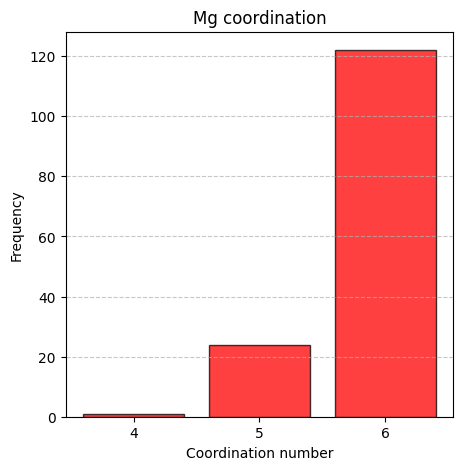

In [ ]:
plot_histogram('Mg', '3', 2.3)

Processing sample folders:   0%|          | 1/6550 [00:19<36:08:03, 19.86s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom O>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>]
[<Atom OE2>, <Atom O>, <Atom O>, <Atom OD1>, <Atom O>]
[<Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OE1>]

Ion <Atom ZN> has coordination number: 6

Ion <Atom ZN> has coordination number: 5

Ion <Atom ZN> has coordination number: 5


Processing sample folders:   0%|          | 2/6550 [00:26<22:08:38, 12.17s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 3/6550 [00:33<17:28:26,  9.61s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>, <Atom O>, <Atom OD1>]


Processing sample folders:   0%|          | 4/6550 [00:51<23:35:16, 12.97s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OD1>, <Atom OE1>, <Atom O>, <Atom NE2>, <Atom OD2>]
[<Atom OE1>, <Atom O>, <Atom O>, <Atom NE2>, <Atom OE2>]
[<Atom OXT>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 5/6550 [00:58<19:40:34, 10.82s/it]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>]
[<Atom O>, <Atom OD1>, <Atom NE2>, <Atom O>, <Atom OD2>]
[<Atom OD1>, <Atom OD2>, <Atom OE1>, <Atom O>, <Atom OE1>, <Atom OE2>]


Processing sample folders:   0%|          | 6/6550 [01:07<18:37:44, 10.25s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom OD1>, <Atom O>, <Atom OE2>]
[<Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OD2>]


Processing sample folders:   0%|          | 7/6550 [01:11<14:55:30,  8.21s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom O>, <Atom OD2>, <Atom NE2>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OE1>, <Atom O>]
[<Atom OE1>, <Atom O>, <Atom OE2>, <Atom OE2>, <Atom OE1>]


Processing sample folders:   0%|          | 9/6550 [01:13<8:24:04,  4.62s/it] 

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD1>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom O>, <Atom OD2>]


Processing sample folders:   0%|          | 10/6550 [01:19<9:10:59,  5.06s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom O>, <Atom OD1>]
[<Atom O>, <Atom O>, <Atom OD2>, <Atom OXT>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OD1>, <Atom O>, <Atom NE2>, <Atom O>]


Processing sample folders:   0%|          | 11/6550 [01:28<11:16:28,  6.21s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom OE1>, <Atom OE2>]


Processing sample folders:   0%|          | 12/6550 [01:37<12:22:56,  6.82s/it]

Multiple models found: 50. Using the last model.
[<Atom NE2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom OD2>]
[<Atom O>, <Atom O>, <Atom OE1>, <Atom OD1>, <Atom OD2>]
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 13/6550 [01:43<11:58:42,  6.60s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OE2>, <Atom OE1>, <Atom O>]
[<Atom OD1>, <Atom OE1>, <Atom OD2>, <Atom OXT>, <Atom OE2>]
[<Atom NE2>, <Atom NE2>, <Atom OE1>, <Atom OE2>, <Atom NE2>]


Processing sample folders:   0%|          | 14/6550 [01:59<16:56:17,  9.33s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom OD2>, <Atom OG>, <Atom O>]
[<Atom OG>, <Atom O>, <Atom O>, <Atom NE2>, <Atom O>]
[<Atom OE1>, <Atom OE2>, <Atom OE2>, <Atom OE1>]


Processing sample folders:   0%|          | 15/6550 [02:10<17:41:33,  9.75s/it]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>]
[<Atom OE1>, <Atom O>, <Atom O>, <Atom OE2>, <Atom OD2>, <Atom OD1>]
[<Atom OE2>, <Atom OE1>, <Atom OE1>, <Atom OD1>, <Atom O>, <Atom OD2>]


Processing sample folders:   0%|          | 16/6550 [02:13<14:14:47,  7.85s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom ND1>, <Atom OE1>, <Atom O>, <Atom NE2>]
[<Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom OD1>]


Processing sample folders:   0%|          | 17/6550 [02:21<14:18:50,  7.89s/it]

Multiple models found: 50. Using the last model.
[<Atom NE2>, <Atom O>, <Atom O>, <Atom O>]
[<Atom NE2>, <Atom O>, <Atom NE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 18/6550 [02:30<15:04:29,  8.31s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom NE2>, <Atom O>]


Processing sample folders:   0%|          | 19/6550 [02:40<15:41:09,  8.65s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 20/6550 [02:53<18:19:23, 10.10s/it]

Multiple models found: 50. Using the last model.
[<Atom OD1>, <Atom O>, <Atom O>, <Atom NE2>, <Atom OXT>]
[<Atom NE2>, <Atom O>, <Atom NE2>, <Atom OD1>]
[<Atom O>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 21/6550 [02:59<16:10:20,  8.92s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OD1>, <Atom OD2>, <Atom OE2>]
[<Atom OD1>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OXT>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 22/6550 [03:15<19:46:25, 10.90s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom O>, <Atom NE2>]
[<Atom O>, <Atom OG>, <Atom NE2>, <Atom O>]
[<Atom NE2>, <Atom OD2>, <Atom OD1>, <Atom OE2>, <Atom OE1>, <Atom O>]


Processing sample folders:   0%|          | 23/6550 [03:25<19:40:43, 10.85s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom NE2>, <Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>]
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom OE2>]


Processing sample folders:   0%|          | 24/6550 [03:38<20:29:28, 11.30s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE1>, <Atom OE2>]
[<Atom NE2>, <Atom OD1>, <Atom OD2>, <Atom OD2>, <Atom OD1>]


Processing sample folders:   0%|          | 25/6550 [03:40<15:43:23,  8.67s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>]
[<Atom O>, <Atom OE2>, <Atom O>, <Atom O>]
[<Atom OE1>, <Atom OE2>, <Atom OE1>, <Atom OE2>]


Processing sample folders:   0%|          | 26/6550 [03:58<20:36:31, 11.37s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom OD2>]
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom OE2>, <Atom OE1>]
[<Atom OE1>, <Atom OE2>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 27/6550 [03:59<15:07:29,  8.35s/it]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom OD1>, <Atom OD1>, <Atom OD2>]
[<Atom O>, <Atom O>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>]


Processing sample folders:   0%|          | 28/6550 [04:08<15:20:43,  8.47s/it]

Multiple models found: 50. Using the last model.
[<Atom OE2>, <Atom OD1>, <Atom O>, <Atom OE1>, <Atom OD2>, <Atom O>]
[<Atom OE2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom O>]
[<Atom OE2>, <Atom OE1>, <Atom OE2>, <Atom OE2>, <Atom OE1>]


Processing sample folders:   0%|          | 29/6550 [04:14<14:00:13,  7.73s/it]

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom O>, <Atom OD2>, <Atom O>, <Atom OE1>]
[<Atom ND1>, <Atom O>, <Atom O>, <Atom OE2>, <Atom O>]
[<Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>, <Atom O>]


Processing sample folders:   0%|          | 30/6550 [04:22<14:13:10,  7.85s/it]

Multiple models found: 50. Using the last model.
[<Atom OD2>, <Atom O>, <Atom OE1>, <Atom O>, <Atom OE2>]
[<Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>, <Atom O>]
[<Atom OE2>, <Atom OE1>, <Atom O>, <Atom NE2>, <Atom O>]


Processing sample folders:   4%|▍         | 252/6550 [04:29<08:23, 12.50it/s]  

Multiple models found: 50. Using the last model.
[<Atom O>, <Atom OD2>, <Atom OD1>, <Atom O>, <Atom O>]
[<Atom OE1>, <Atom O>, <Atom OE2>, <Atom O>, <Atom OE1>, <Atom OE2>]
[<Atom O>, <Atom OD1>, <Atom OD2>, <Atom OD2>, <Atom OD1>]


Processing sample folders: 100%|██████████| 6550/6550 [04:33<00:00, 23.99it/s]  


90
Counter({5: 51, 6: 26, 4: 11, 3: 2})
Histogram saved as Zn Coordination Numbers-3


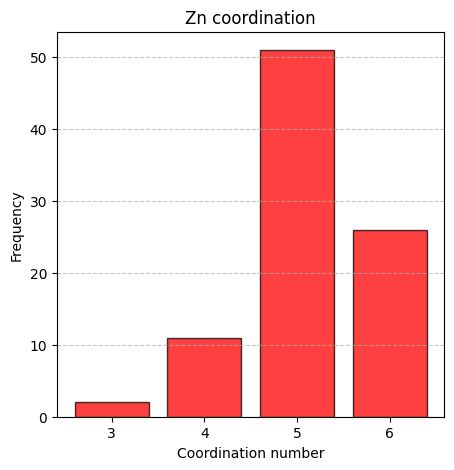

In [ ]:
plot_histogram('Zn', '3', 2.)

Processing sample folders:   0%|          | 1/6196 [00:34<59:56:58, 34.84s/it]

Fully simulated. Using the last model.

Ion <Atom CA> has coordination number: 6

Ion <Atom CA> has coordination number: 7

Ion <Atom CA> has coordination number: 7

Ion <Atom CA> has coordination number: 7


Processing sample folders:   0%|          | 2/6196 [00:59<49:47:50, 28.94s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 3/6196 [01:05<31:55:23, 18.56s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 4/6196 [01:19<28:36:07, 16.63s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 5/6196 [01:28<23:58:11, 13.94s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 6/6196 [02:32<53:16:17, 30.98s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 7/6196 [02:44<42:35:39, 24.78s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 8/6196 [02:52<33:14:10, 19.34s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 9/6196 [03:35<45:49:15, 26.66s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 10/6196 [04:54<73:43:03, 42.90s/it]

Not fully simulated.


Processing sample folders:   0%|          | 11/6196 [05:26<67:46:51, 39.45s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 12/6196 [05:48<58:51:04, 34.26s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 13/6196 [06:23<59:05:18, 34.40s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 14/6196 [06:59<59:59:41, 34.94s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 15/6196 [07:30<58:09:54, 33.88s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 16/6196 [08:01<56:33:44, 32.95s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 17/6196 [08:21<49:52:02, 29.05s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 18/6196 [08:36<42:22:33, 24.69s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 19/6196 [08:50<36:56:03, 21.53s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 20/6196 [09:44<53:50:52, 31.39s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 21/6196 [09:47<39:10:22, 22.84s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 22/6196 [10:32<50:44:48, 29.59s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 23/6196 [10:44<41:28:59, 24.19s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 24/6196 [11:01<37:57:02, 22.14s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 26/6196 [11:10<23:51:23, 13.92s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 27/6196 [11:43<31:59:46, 18.67s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 28/6196 [12:11<35:57:17, 20.99s/it]

Fully simulated. Using the last model.


Processing sample folders:   5%|▍         | 282/6196 [12:31<20:36,  4.78it/s]  

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:  73%|███████▎  | 4506/6196 [12:34<00:03, 440.39it/s]

Not fully simulated.


Processing sample folders:  91%|█████████▏| 5662/6196 [12:50<01:12,  7.35it/s]

Not fully simulated.
Histogram saved as Ca Coordination Numbers-4


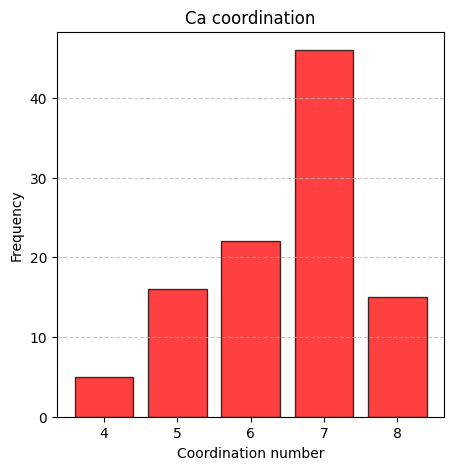

In [ ]:
plot_histogram('Ca', '4', 2.6)

Processing sample folders:   0%|          | 1/5776 [00:19<30:31:15, 19.03s/it]

Fully simulated. Using the last model.
Ion submerged in water
Ion submerged in water

Ion <Atom MG> has coordination number: 6

Ion <Atom MG> has coordination number: 6


Processing sample folders:   0%|          | 2/5776 [00:23<16:23:08, 10.22s/it]

Fully simulated. Using the last model.
Ion submerged in water
Not fully simulated.


Processing sample folders:   0%|          | 3/5776 [01:23<53:26:20, 33.32s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 4/5776 [01:53<50:48:23, 31.69s/it]

Not fully simulated.


Processing sample folders:   0%|          | 6/5776 [01:58<26:13:35, 16.36s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 7/5776 [02:24<30:12:03, 18.85s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 8/5776 [02:43<30:24:08, 18.98s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 9/5776 [02:50<24:58:31, 15.59s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 10/5776 [03:10<26:57:10, 16.83s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 11/5776 [03:54<39:59:52, 24.98s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 12/5776 [04:24<42:17:34, 26.41s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 13/5776 [05:13<52:53:59, 33.05s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 14/5776 [05:28<44:03:09, 27.52s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 15/5776 [05:30<32:12:11, 20.12s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 16/5776 [05:50<31:52:02, 19.92s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 17/5776 [05:54<24:31:34, 15.33s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 18/5776 [07:03<49:59:45, 31.26s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 19/5776 [07:08<37:32:27, 23.48s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 20/5776 [07:27<35:28:04, 22.18s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 21/5776 [08:17<48:35:27, 30.40s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 22/5776 [08:40<45:18:38, 28.35s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 23/5776 [08:59<40:39:41, 25.44s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 24/5776 [09:46<51:03:50, 31.96s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 25/5776 [10:12<48:05:14, 30.10s/it]

Fully simulated. Using the last model.
Ion submerged in water


Processing sample folders:   0%|          | 26/5776 [10:34<44:22:06, 27.78s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 27/5776 [10:36<31:43:52, 19.87s/it]

Fully simulated. Using the last model.


Processing sample folders:   0%|          | 28/5776 [10:38<23:17:27, 14.59s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 29/5776 [11:32<41:57:21, 26.28s/it]

Fully simulated. Using the last model.


Processing sample folders:   1%|          | 30/5776 [12:16<39:12:16, 24.56s/it]

Fully simulated. Using the last model.
Histogram saved as Mg Coordination Numbers-4


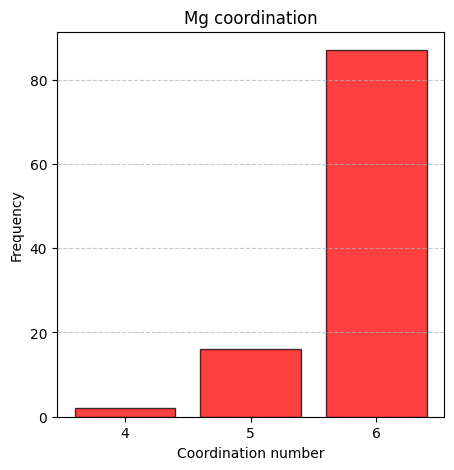

In [ ]:
plot_histogram('Mg', '4', 2.3)

In [ ]:
plot_histogram('Zn', '4', 2.)